In [8]:
import numpy as np
import matplotlib.pyplot as plt
from lm_polygraph.ue_metrics.pred_rej_area import PredictionRejectionArea
from lm_polygraph.ue_metrics.ue_metric import (
    get_random_scores,
    normalize_metric,
)
import sklearn
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from collections import defaultdict
from sacrebleu import CHRF, BLEU
from lm_polygraph.utils.manager import UEManager

from lm_polygraph.ue_metrics import PredictionRejectionArea

In [4]:
def load_managers(dataset, model='llama', model_type='base', suff ='test_qe_enriched'):
    prefix = '' if model_type == 'base' else '_instruct'

    train_manager =  UEManager.load(f'processed_mans/{model}{prefix}_{dataset}_train_{suff}.man') if suff!='' else  UEManager.load(f'mans/{model}{prefix}_{dataset}_train.man') 

    return train_manager

def extract_and_prepare_data_train(dataset, methods_dict, all_metrics, model='llama', model_type='base', suff ='test_qe_enriched'):
    train_manager = load_managers(dataset, model, model_type, suff=suff)

    full_ue_methods = list(methods_dict.keys())
    ue_methods = list(methods_dict.values())

    
    train_sequences = train_manager.stats['greedy_tokens']
    train_texts = train_manager.stats['greedy_texts']
    train_targets = train_manager.stats['target_texts']

    train_gen_lengths = np.array([len(seq) for seq in train_sequences])
    # gen_lengths = np.array([len(seq) for seq in sequences])

    # Get train and test values for metrics and UE, remove union of nans
    test_nans = []
    train_nans = []

    train_metric_values = {}
    test_metric_values = {}
    for metric in all_metrics:
        # values = np.array(manager.gen_metrics[('sequence', metric)])
        # test_metric_values[metric] = np.array(values)
        # test_nans.extend(np.argwhere(np.isnan(values)).flatten())

        train_values = np.array(train_manager.gen_metrics[('sequence', metric)])
        train_metric_values[metric] = np.array(train_values)
        train_nans.extend(np.argwhere(np.isnan(train_values)).flatten())

    train_ue_values = {}
    # test_ue_values = {}
    for i, method in enumerate(full_ue_methods):
        train_values = np.array(train_manager.estimations[('sequence', method)])
        train_ue_values[ue_methods[i]] = train_values
        train_nans.extend(np.argwhere(np.isnan(train_values)).flatten())

        # values = np.array(manager.estimations[('sequence', method)])
        # test_ue_values[ue_methods[i]] = values
        # test_nans.extend(np.argwhere(np.isnan(values)).flatten())

    train_nans = np.unique(train_nans).astype(int)
    # test_nans = np.unique(test_nans).astype(int)

    # Remove nans
    for metric in all_metrics:
        # test_metric_values[metric] = np.delete(test_metric_values[metric], test_nans)
        train_metric_values[metric] = np.delete(train_metric_values[metric], train_nans)

    for method in ue_methods:
        # test_ue_values[method] = np.delete(test_ue_values[method], test_nans)
        train_ue_values[method] = np.delete(train_ue_values[method], train_nans)

    train_gen_lengths = np.delete(train_gen_lengths, train_nans)

    return train_ue_values, train_metric_values, train_gen_lengths


In [5]:
methods_dict = {
    'MaximumSequenceProbability': 'MSP',
    'Perplexity': 'PPL',
    'MeanTokenEntropy': 'MTE',
    'MonteCarloSequenceEntropy': 'MCSE',
    'MonteCarloNormalizedSequenceEntropy': 'MCNSE',
}

DATASETS = [
    'wmt14_deen',
    'wmt14_fren',
    'wmt14_csen',
    'wmt14_ruen',
    'wmt19_ruen',
    'wmt19_fien',
    'wmt19_deen',
    'wmt19_lten'
]

all_metrics = ['Comet-wmt22-comet-da', 'XComet-XCOMET-XXL', 'metricx-metricx-24-hybrid-large-v2p6']
all_methods =['MSP', 'PPL', 'MTE', 'MCSE', 'MCNSE']

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import linregress
import numpy as np
import pandas as pd

sns.set(style="whitegrid", font_scale=1.4, rc={"font.family": "serif"})

methrics_dict ={
  'Comet':'Comet', 'XComet-XCOMET-XXL' :'XComet-XXL', 'metricx-metricx-24-hybrid-large-v2p6' :'MetricX-Large' ,
  'AlignScoreInputOutput':'Align Score', 'Accuracy':'Acc', 'AlignScoreInputOutput':'Align Score','Rouge_rougeL':'Rouge L'
}

def format_dataset_name(raw_name):
    try:
        prefix, lang_pair = raw_name.split("_")
        prefix = prefix.upper()

        if len(lang_pair) == 4:  # e.g., fren → Fr-En
            src = lang_pair[:2].capitalize()
            tgt = lang_pair[2:].capitalize()
            lang_fmt = f"{src}-{tgt}"
        else:
            lang_fmt = lang_pair.upper()

        return f"{prefix} {lang_fmt}"
    except Exception:
        return raw_name.upper()


def plot_metric_vs_length(
    gen_lengths, metric_values,
    metric_name, dataset_name,
    mode='Train', save_path='plot.pdf', model=''
):
    from sklearn.linear_model import LinearRegression
    from scipy.stats import linregress

    # Trim outliers
    upper_q, lower_q = np.quantile(gen_lengths, [0.95, 0.05])
    mask = (gen_lengths > lower_q) & (gen_lengths < upper_q)
    gen_lengths = gen_lengths[mask]
    metric_values = metric_values[mask]

    # Normalize
    scaler_len = MinMaxScaler()
    scaler_val = MinMaxScaler()

    norm_len = scaler_len.fit_transform(gen_lengths[:, None]).squeeze()
    norm_val = scaler_val.fit_transform(metric_values[:, None]).squeeze()

    # Bin and smooth
    df = pd.DataFrame({"length": norm_len, "metric": norm_val})
    grouped = df.groupby("length").agg(['mean', 'sem'])
    x_vals = grouped.index.values
    y_vals = grouped['metric']['mean'].values
    y_errs = grouped['metric']['sem'].values

    # Fit regression (on raw normalized data)
    linreg = LinearRegression().fit(norm_len[:, None], norm_val)
    slope = linreg.coef_[0]

    # Also compute p-value
    slope_, intercept_, r_val, p_val, std_err = linregress(norm_len, norm_val)

    x_line = np.linspace(0, 1, 100)
    y_line = linreg.predict(x_line[:, None])

    # Plot
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(x_vals, y_vals, label='AVG metric value', color="navy")
    ax.fill_between(x_vals, y_vals - y_errs, y_vals + y_errs, alpha=0.2, color="navy")
    ax.plot(x_line, y_line, linestyle='--', color='crimson', label='Regression Line')

    ax.text(0.05, 0.95,
            f"Slope: {slope:.2f}\n$p$-value: {p_val:.3f}",
            transform=ax.transAxes, fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='gray'))

    pretty_dataset = format_dataset_name(dataset_name)
    ax.set_title(f"{methrics_dict[metric_name]} vs. Length ({pretty_dataset})", fontsize=14)
    ax.set_xlabel("Generated sequence length (normalized)")
    ax.set_ylabel(f"{methrics_dict[metric_name]} (normalized)")
    ax.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()


# Metric trends plots

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os 
models =['llama','gemma','eurollm']
for model in models:

    for dataset in DATASETS:
        train_ue_values, train_metric_values, train_gen_lengths = extract_and_prepare_data_train(dataset, methods_dict, all_metrics, model=model, suff='full_enriched')

        for metric in all_metrics:
            os.makedirs(f'{model}/{metric}', exist_ok=True)

            plot_metric_vs_length(
                gen_lengths=np.array(train_gen_lengths),
                metric_values=np.array(train_metric_values[metric]),
                metric_name=metric,
                dataset_name=dataset,
                mode='Train',
                save_path=f'{model}/{metric}/{dataset}_{metric}_{model}_train.pdf',
                # model = model
            )


For xsum and gsm8k

/home/maiya.goloburda/.conda/envs/detrend/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7f458a8efcd0>]


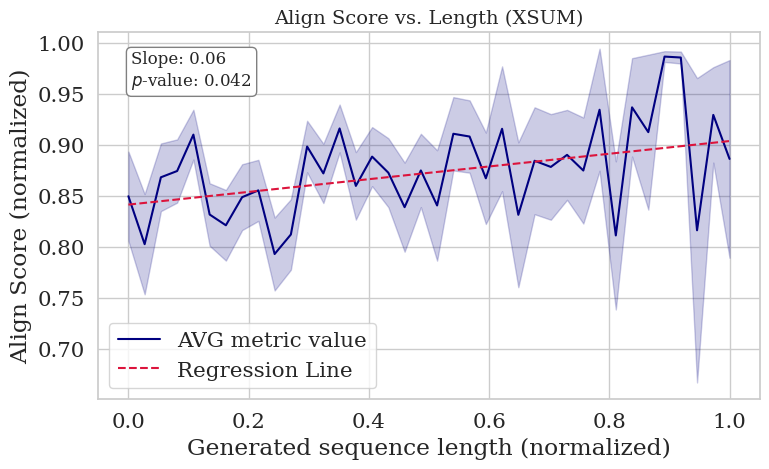

/home/maiya.goloburda/.conda/envs/detrend/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7f45dda3e110>]


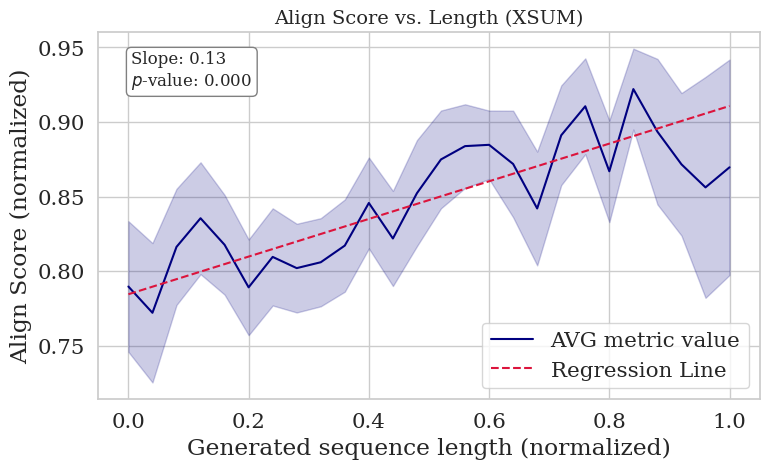

In [7]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os 
DATASETS =['xsum']
all_metrics = ['AlignScoreInputOutput']
models =['llama','gemma']
for model in models:

    for dataset in DATASETS:
        train_ue_values, train_metric_values, train_gen_lengths = extract_and_prepare_data_train(dataset, methods_dict, all_metrics, model=model, suff='full_enriched')

        for metric in all_metrics:
            os.makedirs(f'{model}/{metric}', exist_ok=True)

            plot_metric_vs_length(
                gen_lengths=np.array(train_gen_lengths),
                metric_values=np.array(train_metric_values[metric]),
                metric_name=metric,
                dataset_name=dataset,
                mode='Train',
                save_path=f'{model}/{metric}/{dataset}_{metric}_{model}_train.pdf',
                # model = model
            )


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os 
DATASETS =['gsm8k']
all_metrics=['Accuracy']
models =['llama','gemma']
for model in models:

    for dataset in DATASETS:
        train_ue_values, train_metric_values, train_gen_lengths = extract_and_prepare_data_hello(dataset, methods_dict, all_metrics, model=model, suff='full_enriched')

        for metric in all_metrics:
            os.makedirs(f'{model}/{metric}', exist_ok=True)

            plot_metric_vs_length(
                gen_lengths=np.array(train_gen_lengths),
                metric_values=np.array(train_metric_values[metric]),
                metric_name=metric,
                dataset_name=dataset,
                mode='Train',
                save_path=f'{model}/{metric}/{dataset}_{metric}_{model}_train.pdf',
                # model = model
            )


# UE metrics trends

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
methods_dict = {
    'MaximumSequenceProbability': 'MSP',
    'Perplexity': 'PPL',
    'MeanTokenEntropy': 'MTE',
    'MonteCarloSequenceEntropy': 'MCSE',
    'MonteCarloNormalizedSequenceEntropy': 'MCNSE',
        'LexicalSimilarity_rougeL': 'LSRL'
}

methrics_dict ={
  'MSP':'MSP', 'PPL' :'PPL', 'MTE' :'MTE',  'MCSE':'MCSE', 'MCNSE':'MCNSE', 'LSRL': 'LSRL'
}

DATASETS = [
    'wmt14_deen',
    'wmt14_fren',
    'wmt14_csen',
    'wmt14_ruen',
    'wmt19_ruen',
    'wmt19_fien',
    'wmt19_deen',
    'wmt19_lten'
]

all_metrics = ['Comet-wmt22-comet-da', 'XComet-XCOMET-XXL', 'metricx-metricx-24-hybrid-large-v2p6']
models = ['llama', 'gemma', 'eurollm']

for model in models:
    for dataset in DATASETS:
        train_ue_values, train_metric_values, train_gen_lengths = extract_and_prepare_data_train(dataset, methods_dict, all_metrics, model=model, suff='full_enriched')

        for metric, metric_short  in methods_dict.items():
            os.makedirs(f'{model}/{metric}', exist_ok=True)
            plot_metric_vs_length(
                gen_lengths=np.array(train_gen_lengths),
                metric_values=np.array(train_ue_values[metric_short]),
                metric_name=metric_short,
                dataset_name=dataset,
                mode='Train',
                save_path=f'{model}/{metric}/{dataset}_{metric}_{model}_train.pdf',
                # model = model
            )

# Detrending results

In [5]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
import numpy as np


def format_dataset_name(raw_name):
    try:
        prefix, lang_pair = raw_name.split("_")
        prefix = prefix.upper()

        if len(lang_pair) == 4:  # e.g., fren → Fr-En
            src = lang_pair[:2].capitalize()
            tgt = lang_pair[2:].capitalize()
            lang_fmt = f"{src}-{tgt}"
        else:
            lang_fmt = lang_pair.upper()

        return f"{prefix} {lang_fmt}"
    except Exception:
        return raw_name.upper()
def plot_raw_and_detrended_vs_length(
    lengths,
    raw_scores,
    detr_scores,
    metric_name='Metric',
    dataset_name='Dataset',
    save_path=None
):
    # Convert to numpy arrays
    lengths = np.array(lengths).reshape(-1)
    raw_scores = np.array(raw_scores).reshape(-1)
    detr_scores = np.array(detr_scores).reshape(-1)

    # Remove outliers: keep values between 5th and 95th percentile
    lower, upper = np.percentile(lengths, [2.5, 97.5])
    mask = (lengths >= lower) & (lengths <= upper)
    lengths = lengths[mask]
    raw_scores = raw_scores[mask]
    detr_scores = detr_scores[mask]

    # Fit regressions
    reg_raw = LinearRegression().fit(lengths[:, None], raw_scores)
    reg_detr = LinearRegression().fit(lengths[:, None], detr_scores)

    slope_raw = reg_raw.coef_[0]
    slope_detr = reg_detr.coef_[0]

    _, _, _, pval_raw, _ = linregress(lengths, raw_scores)
    _, _, _, pval_detr, _ = linregress(lengths, detr_scores)

    # Prediction lines
    x_line = np.linspace(lengths.min(), lengths.max(), 100)
    y_raw_line = reg_raw.predict(x_line[:, None])
    y_detr_line = reg_detr.predict(x_line[:, None])

    # Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(lengths, raw_scores, color='navy', alpha=0.2, label='Raw')
    plt.plot(x_line, y_raw_line, '--', color='navy', label=f'Raw Fit (slope={slope_raw:.2f})')

    plt.scatter(lengths, detr_scores, color='crimson', alpha=0.2, label='Detrended')
    plt.plot(x_line, y_detr_line, '--', color='crimson', label=f'Detr. Fit (slope={slope_detr:.2f})')

    plt.title(f"{metric_name} vs. Length ({format_dataset_name(dataset_name)})")
    plt.xlabel("Generated Sequence Length")
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)


In [2]:
methods_dict = {
    'MaximumSequenceProbability': 'MSP',
    'Perplexity': 'PPL',
    'MeanTokenEntropy': 'MTE',
    'MonteCarloSequenceEntropy': 'MCSE',
    'MonteCarloNormalizedSequenceEntropy': 'MCNSE',
}

DATASETS = [
    'wmt14_deen',
    'wmt14_fren',
    'wmt14_csen',
    'wmt14_ruen',
    'wmt19_ruen',
    'wmt19_fien',
    'wmt19_deen',
    'wmt19_lten'
]

all_metrics = ['Comet-wmt22-comet-da', 'XComet-XCOMET-XXL', 'metricx-metricx-24-hybrid-large-v2p6']
all_methods =['MSP', 'PPL', 'MTE', 'MCSE', 'MCNSE']

In [13]:
from utils import score_ues, extract_and_prepare_data

def detrend_ue(datasets, model, model_type, all_metrics, ue_methods, methods_dict, task='nmt', return_unprocessed=False):
    ue_scores = defaultdict(list)
    ue_coefs = defaultdict(list)
    ave_test_metric_values = {}

    if len(all_metrics) == 1 and len(datasets) > 1:
        all_metrics = all_metrics * len(datasets)
    elif len(all_metrics) != len(datasets):
        raise ValueError('Number of metrics and datasets must be the same')

    for metric, dataset in zip(all_metrics, datasets):
        train_ue_values, \
        test_ue_values, \
        train_metric_values, \
        test_metric_values, \
        train_gen_lengths, \
        gen_lengths = extract_and_prepare_data(dataset, methods_dict, [metric], model=model, model_type=model_type, task=task)

        ave_test_metric_values[dataset] = np.mean(test_metric_values[metric])

        upper_q = np.quantile(train_gen_lengths, 0.95)
        lower_q = np.quantile(train_gen_lengths, 0.05)
        below_q_ids = (train_gen_lengths < upper_q) & (train_gen_lengths > lower_q)
        print(f'{model} {dataset} Below q ids: {below_q_ids.sum()}')
        train_gen_lengths = train_gen_lengths[below_q_ids]

        for method in ue_methods:
            train_ue_values[method] = train_ue_values[method][below_q_ids]

        train_normalized_ue_values = {}
        test_normalized_ue_values = {}

        ue_residuals = {}

        for method in ue_methods:
            gen_length_scaler = MinMaxScaler()
            train_gen_lengths_normalized = gen_length_scaler.fit_transform(train_gen_lengths[:, np.newaxis]).squeeze()
            test_gen_lengths_normalized = gen_length_scaler.transform(gen_lengths[:, np.newaxis]).squeeze()

            scaler = MinMaxScaler()
            train_normalized_ue_values[method] = scaler.fit_transform(train_ue_values[method][:, np.newaxis]).squeeze()
            test_normalized_ue_values[method] = scaler.transform(test_ue_values[method][:, np.newaxis]).squeeze()

            linreg = sklearn.linear_model.LinearRegression()
            linreg.fit(train_gen_lengths_normalized[:, np.newaxis], train_normalized_ue_values[method])
            ue_coefs[method].append(linreg.coef_[0])

            ue_residuals[method] = test_normalized_ue_values[method] - linreg.predict(test_gen_lengths_normalized[:, np.newaxis])
            scaler = MinMaxScaler()
            norm_residuals = scaler.fit_transform(ue_residuals[method][:, np.newaxis]).squeeze()
            linreg = sklearn.linear_model.LinearRegression()
            linreg.fit(test_gen_lengths_normalized[:, np.newaxis], norm_residuals)
            ue_coefs[method].append(linreg.coef_[0])

            met_vals = test_metric_values[metric]
            raw_score = score_ues(test_ue_values[method], met_vals)
            raw_norm_score = score_ues(test_normalized_ue_values[method], met_vals)
            detrended_score = score_ues(ue_residuals[method], met_vals)

            ue_scores[f'{method}_raw'].append(raw_score)
            ue_scores[f'{method}_detr'].append(detrended_score)
            ue_scores[f'{method}_raw_full'].append(test_normalized_ue_values[method])
            ue_scores[f'{method}_detr_full'].append(ue_residuals[method])


    if return_unprocessed:
        return ue_scores, ue_coefs, ave_test_metric_values,test_gen_lengths_normalized[:, np.newaxis]

    raw_column_values = []
    detr_column_values = []
    for _id, _ in enumerate(datasets):
        raw_column_values.append([ue_scores[f'{method}_raw'][_id] for method in ue_methods])
        detr_column_values.append([ue_scores[f'{method}_detr'][_id] for method in ue_methods])

        metric_raw_scores = np.array([ue_scores[f'{method}_raw'][_id] for method in ue_methods])
        metric_detr_scores = np.array([ue_scores[f'{method}_detr'][_id] for method in ue_methods])

        top_raw_id = np.argmax(metric_raw_scores)
        top_detr_id = np.argmax(metric_detr_scores)

        for method in ue_methods:
            ue_scores[f'{method}_raw'][_id] = f'{ue_scores[f"{method}_raw"][_id]:.2f}'
            ue_scores[f'{method}_detr'][_id] = f'{ue_scores[f"{method}_detr"][_id]:.2f}'

        # wrap best detr method in bold
        ue_scores[f'{ue_methods[top_detr_id]}_detr'][_id] = f'\\textbf{{{ue_scores[f"{ue_methods[top_detr_id]}_detr"][_id]}}}'
        # wrap best raw method in underline
        ue_scores[f'{ue_methods[top_raw_id]}_raw'][_id] = f'\\underline{{{ue_scores[f"{ue_methods[top_raw_id]}_raw"][_id]}}}'

    total_column_values = []
    for raw_column, detr_column in zip(raw_column_values, detr_column_values):
        total_column_values.append([val for pair in zip(raw_column, detr_column) for val in pair])

    raw_method_id_ranks = np.flip(np.argsort(raw_column_values, axis=-1), axis=-1)
    raw_mean_ranks = [np.nonzero(raw_method_id_ranks == method_i)[1].mean() for method_i, _ in enumerate(ue_methods)]

    detr_method_id_ranks = np.flip(np.argsort(detr_column_values, axis=-1), axis=-1)
    detr_mean_ranks = [np.nonzero(detr_method_id_ranks == method_i)[1].mean() for method_i, _ in enumerate(ue_methods)]

    total_method_id_ranks = np.flip(np.argsort(total_column_values, axis=-1), axis=-1)
    total_mean_ranks = [np.nonzero(total_method_id_ranks == method_i)[1].mean() for method_i, _ in enumerate(ue_methods * 2)]

    for method_i, method in enumerate(ue_methods):
        ue_scores[f'{method}_raw'].extend((str(raw_mean_ranks[method_i]), '-', total_mean_ranks[method_i * 2]))
        ue_scores[f'{method}_detr'].extend(('-', str(detr_mean_ranks[method_i]), total_mean_ranks[method_i * 2 + 1]))
    
    return ue_scores, ue_coefs, ave_test_metric_values



def detrend_ue_w_quality(datasets, model, model_type, all_metrics, ue_methods, methods_dict, task='nmt', return_unprocessed=False, quality_fit_sample_size=None):
    ue_scores = defaultdict(list)
    ue_scores_full = {}
    ue_coefs = defaultdict(list)
    ave_test_metric_values = {}

    if len(all_metrics) == 1 and len(datasets) > 1:
        all_metrics = all_metrics * len(datasets)
    elif len(all_metrics) != len(datasets):
        raise ValueError('Number of metrics and datasets must be the same')

    for metric, dataset in zip(all_metrics, datasets):
        train_ue_values, \
        test_ue_values, \
        train_metric_values, \
        test_metric_values, \
        train_gen_lengths, \
        gen_lengths = extract_and_prepare_data(dataset, methods_dict, [metric], model=model, model_type=model_type, task=task)

        ave_test_metric_values[dataset] = np.mean(test_metric_values[metric])

        upper_q = np.quantile(train_gen_lengths, 0.95)
        lower_q = np.quantile(train_gen_lengths, 0.05)
        below_q_ids = (train_gen_lengths < upper_q) & (train_gen_lengths > lower_q)
        print(f'{model} {dataset} Below q ids: {below_q_ids.sum()}')
        train_gen_lengths = train_gen_lengths[below_q_ids]

        for method in ue_methods:
            train_ue_values[method] = train_ue_values[method][below_q_ids]


        train_normalized_ue_values = {}
        test_normalized_ue_values = {}

        train_normalized_metric_values = {}
        test_normalized_metric_values = {}
        ue_residuals = {}
       
        # for metric in all_metrics:
        #     train_metric_values[metric] = train_metric_values[metric][below_q_ids]


        for method in ue_methods:
            gen_length_scaler = MinMaxScaler()
            train_gen_lengths_normalized = gen_length_scaler.fit_transform(train_gen_lengths[:, np.newaxis]).squeeze()
            test_gen_lengths_normalized = gen_length_scaler.transform(gen_lengths[:, np.newaxis]).squeeze()

            scaler = MinMaxScaler()
            train_normalized_ue_values[method] = scaler.fit_transform(train_ue_values[method][:, np.newaxis]).squeeze()
            test_normalized_ue_values[method] = scaler.transform(test_ue_values[method][:, np.newaxis]).squeeze()

            scaler = MinMaxScaler()
            train_normalized_metric_values[method] = scaler.fit_transform(train_metric_values[metric][:, np.newaxis]).squeeze()
            test_normalized_metric_values[method] = scaler.transform(test_metric_values[metric][:, np.newaxis]).squeeze()

            # quality_reg = sklearn.linear_model.LinearRegression()
            # quality_reg.fit(train_gen_lengths_normalized[:, np.newaxis], train_normalized_metric_values[method][below_q_ids])
            # quality_slope = quality_reg.coef_[0]

            if quality_fit_sample_size is not None and quality_fit_sample_size < len(train_gen_lengths):
                sample_indices = np.random.choice(len(train_gen_lengths), size=quality_fit_sample_size, replace=False)
                quality_reg = sklearn.linear_model.LinearRegression()
                quality_reg.fit(
                    train_gen_lengths_normalized[sample_indices, np.newaxis],
                    train_normalized_metric_values[method][sample_indices]
                )
            else:
                quality_reg = sklearn.linear_model.LinearRegression()
                quality_reg.fit(
                    train_gen_lengths_normalized[:, np.newaxis],
                    train_normalized_metric_values[method][below_q_ids]
                )

            # Fit UE ~ length
            linreg = sklearn.linear_model.LinearRegression()
            linreg.fit(train_gen_lengths_normalized[:, np.newaxis], train_normalized_ue_values[method])
            ue_slope = linreg.coef_[0]
            ue_coefs[method].append(ue_slope)

            predicted_quality_trend = quality_reg.predict(test_gen_lengths_normalized[:, np.newaxis])
            # Predict UE trend on test
            predicted_ue_trend = linreg.predict(test_gen_lengths_normalized[:, np.newaxis])


            # joint_reg = sklearn.linear_model.LinearRegression()
            # joint_reg.fit(np.stack([train_gen_lengths_normalized, train_normalized_metric_values[method]], axis=1),
                        # train_normalized_ue_values[method])
            # predicted_trend = joint_reg.predict(np.stack([test_gen_lengths_normalized, test_normalized_metric_values[method]], axis=1))
            # adjusted_ue = test_normalized_ue_values[method] - predicted_trend

            # Residual-based adjustment
            adjusted_ue = test_normalized_ue_values[method] - predicted_ue_trend - predicted_quality_trend

            residual_reg = sklearn.linear_model.LinearRegression()
            residual_reg.fit(test_gen_lengths_normalized[:, np.newaxis], adjusted_ue)
            ue_coefs[method].append(residual_reg.coef_[0])

            met_vals = test_metric_values[metric]
            raw_score = score_ues(test_ue_values[method], met_vals)
            raw_norm_score = score_ues(test_normalized_ue_values[method], met_vals)
            detrended_score = score_ues(adjusted_ue, met_vals)
            ue_scores_full[f'{method}_raw'] = test_normalized_ue_values[method]
            ue_scores_full[f'{method}_detr'] = adjusted_ue
            ue_scores[f'{method}_raw'].append(raw_score)
            ue_scores[f'{method}_detr'].append(detrended_score)
            ue_scores[f'{method}_raw_full'].append(test_normalized_ue_values[method])
            ue_scores[f'{method}_detr_full'].append(adjusted_ue)



    normalized_lengths= test_gen_lengths_normalized.tolist()

    if return_unprocessed:
        return ue_scores, ue_coefs, ave_test_metric_values,  test_gen_lengths_normalized[:, np.newaxis] , test_normalized_metric_values[method]

    raw_column_values = []
    detr_column_values = []
    for _id, _ in enumerate(datasets):
        raw_column_values.append([ue_scores[f'{method}_raw'][_id] for method in ue_methods])
        detr_column_values.append([ue_scores[f'{method}_detr'][_id] for method in ue_methods])

        metric_raw_scores = np.array([ue_scores[f'{method}_raw'][_id] for method in ue_methods])
        metric_detr_scores = np.array([ue_scores[f'{method}_detr'][_id] for method in ue_methods])

        top_raw_id = np.argmax(metric_raw_scores)
        top_detr_id = np.argmax(metric_detr_scores)

        for method in ue_methods:
            ue_scores[f'{method}_raw'][_id] = f'{ue_scores[f"{method}_raw"][_id]:.2f}'
            ue_scores[f'{method}_detr'][_id] = f'{ue_scores[f"{method}_detr"][_id]:.2f}'

        # wrap best detr method in bold
        ue_scores[f'{ue_methods[top_detr_id]}_detr'][_id] = f'\\textbf{{{ue_scores[f"{ue_methods[top_detr_id]}_detr"][_id]}}}'
        # wrap best raw method in underline
        ue_scores[f'{ue_methods[top_raw_id]}_raw'][_id] = f'\\underline{{{ue_scores[f"{ue_methods[top_raw_id]}_raw"][_id]}}}'

    total_column_values = []
    for raw_column, detr_column in zip(raw_column_values, detr_column_values):
        total_column_values.append([val for pair in zip(raw_column, detr_column) for val in pair])

    raw_method_id_ranks = np.flip(np.argsort(raw_column_values, axis=-1), axis=-1)
    raw_mean_ranks = [np.nonzero(raw_method_id_ranks == method_i)[1].mean() for method_i, _ in enumerate(ue_methods)]

    detr_method_id_ranks = np.flip(np.argsort(detr_column_values, axis=-1), axis=-1)
    detr_mean_ranks = [np.nonzero(detr_method_id_ranks == method_i)[1].mean() for method_i, _ in enumerate(ue_methods)]

    total_method_id_ranks = np.flip(np.argsort(total_column_values, axis=-1), axis=-1)
    total_mean_ranks = [np.nonzero(total_method_id_ranks == method_i)[1].mean() for method_i, _ in enumerate(ue_methods * 2)]

    for method_i, method in enumerate(ue_methods):
        ue_scores[f'{method}_raw'].extend((str(raw_mean_ranks[method_i]), '-', total_mean_ranks[method_i * 2]))
        ue_scores[f'{method}_detr'].extend(('-', str(detr_mean_ranks[method_i]), total_mean_ranks[method_i * 2 + 1]))
    
    return ue_scores, ue_coefs, ave_test_metric_values, normalized_lengths


In [ ]:
# model = 'llama'
DATASETS = ['wmt14_deen']
model_type ='base'
methods_dict = {
    'MaximumSequenceProbability': 'MSP',
    'Perplexity': 'PPL',
    'MeanTokenEntropy': 'MTE',
    'MonteCarloSequenceEntropy': 'MCSE',
    'MonteCarloNormalizedSequenceEntropy': 'MCNSE',
    'LexicalSimilarity_rougeL': 'LSRL',
}
models=['llama' ] #, 'gemma', 'eurollm']
for metric in all_metrics:
    for model in models:
        for dataset in DATASETS:
            ue_methods =  list(methods_dict.values())
            ue_scores, _, _, lengths = detrend_ue([dataset], model, model_type, [metric], ue_methods, methods_dict, return_unprocessed=True)
            for ue_method in ue_methods:
                plot_raw_and_detrended_vs_length(lengths, ue_scores[f'{ue_method}_raw_full'][0], ue_scores[f'{ue_method}_detr_full'][0], metric_name=ue_method, dataset_name=dataset, save_path=f"{model}_{ue_method}_{dataset}_comparison.pdf")

/home/maiya.goloburda/.conda/envs/detrend/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7f01093437f0>]


Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7f01099994e0>]
llama xsum Below q ids: 1620


/home/maiya.goloburda/.conda/envs/detrend/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7f00b76db550>]


Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7f0108c70eb0>]
llama gsm8k Below q ids: 1796


/home/maiya.goloburda/.conda/envs/detrend/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7f00b75b5210>]


Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7f00b64a7100>]
gemma xsum Below q ids: 1781


/home/maiya.goloburda/.conda/envs/detrend/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7f0108b69780>]


Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7f0109c06020>]
gemma gsm8k Below q ids: 1798


/tmp/ipykernel_750203/161028695.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 5))


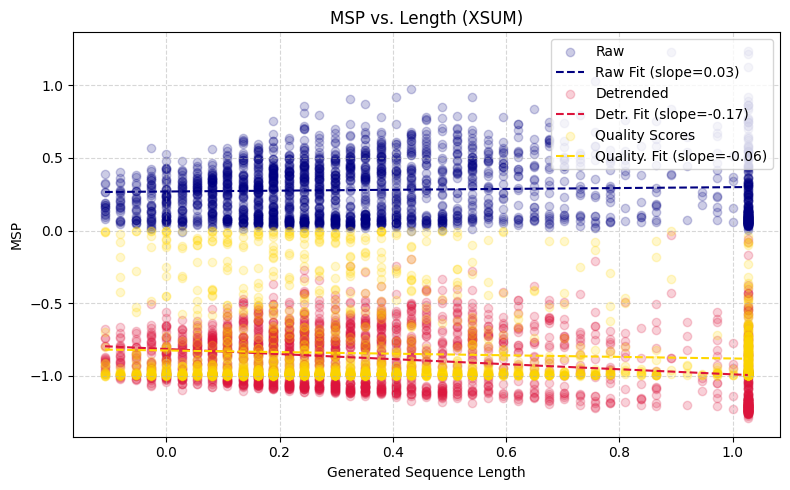

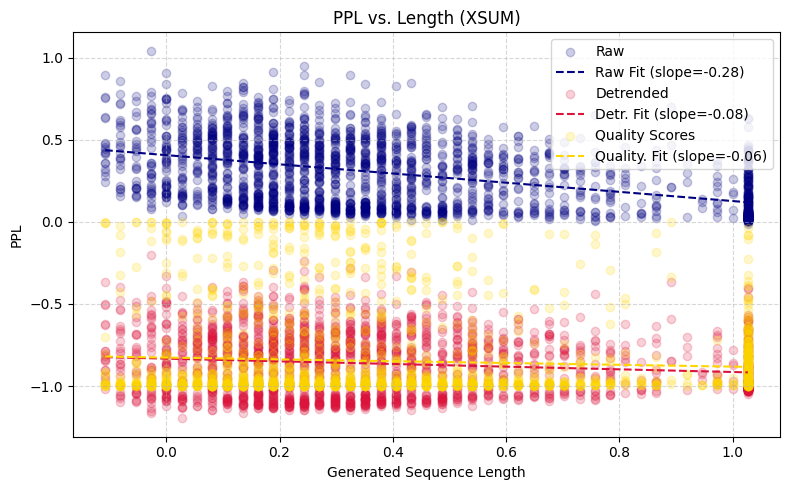

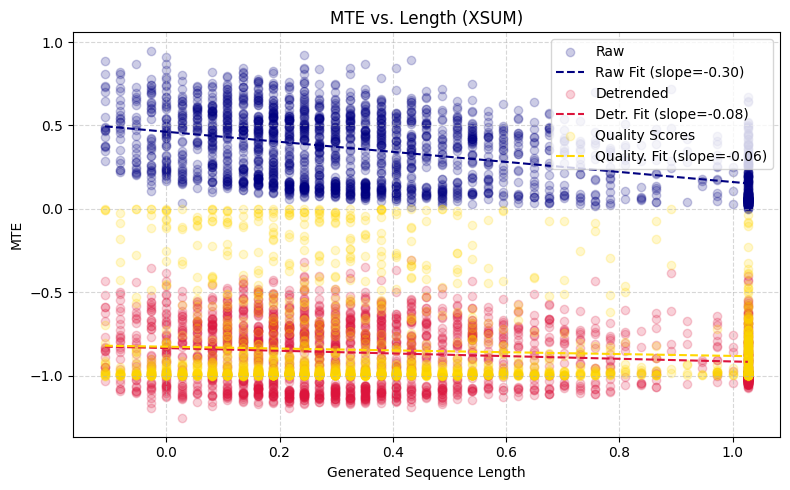

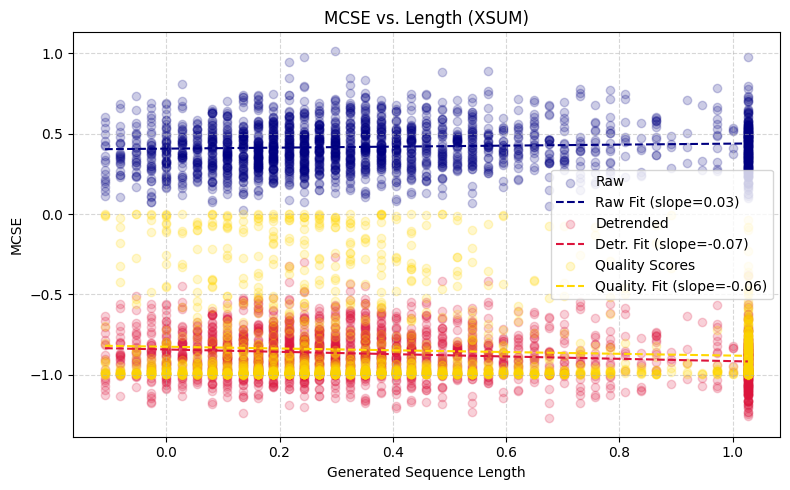

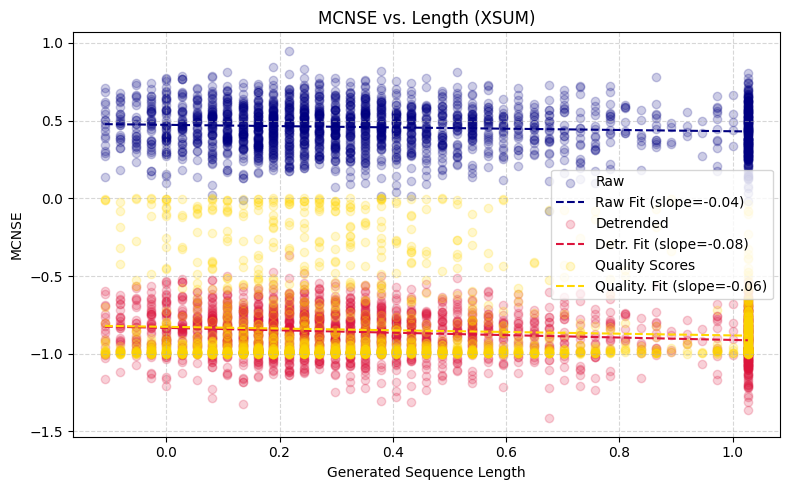

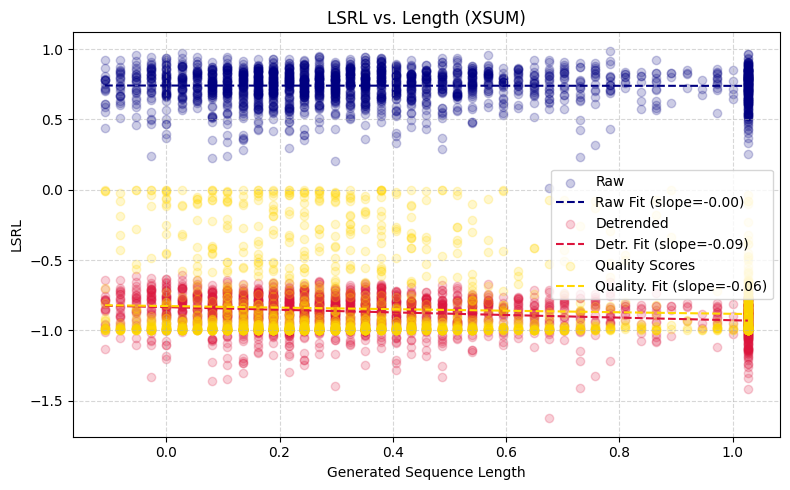

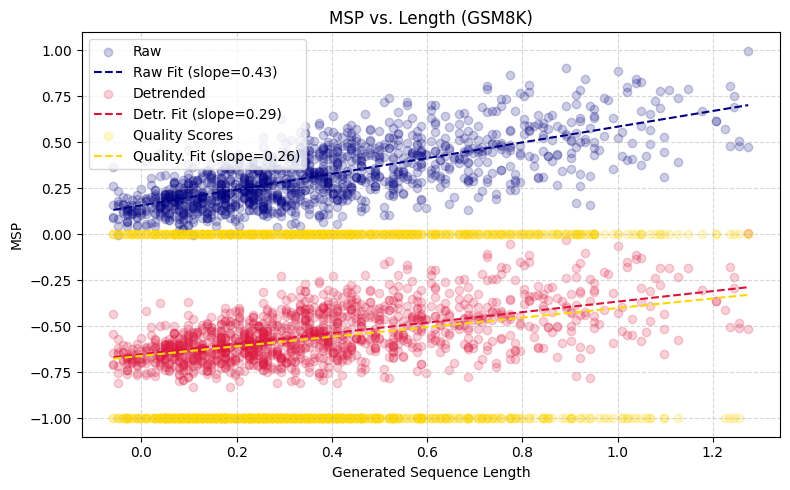

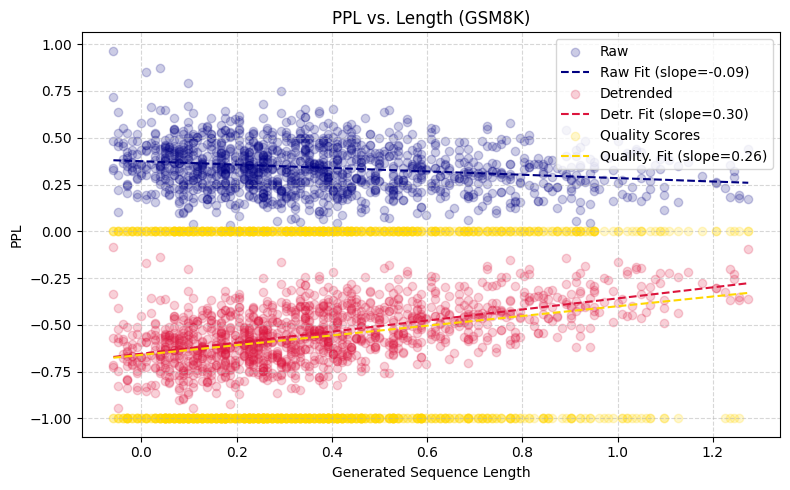

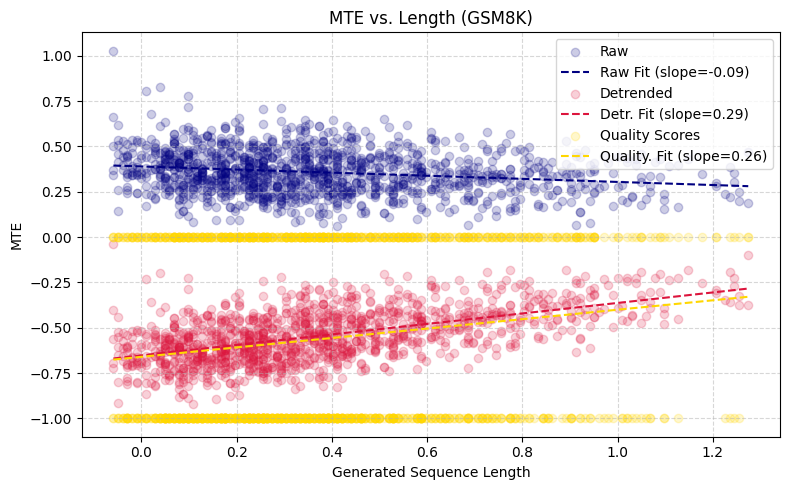

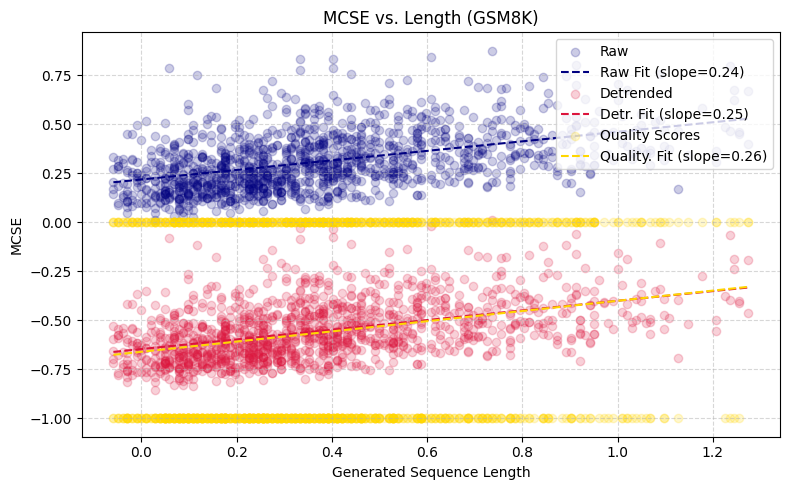

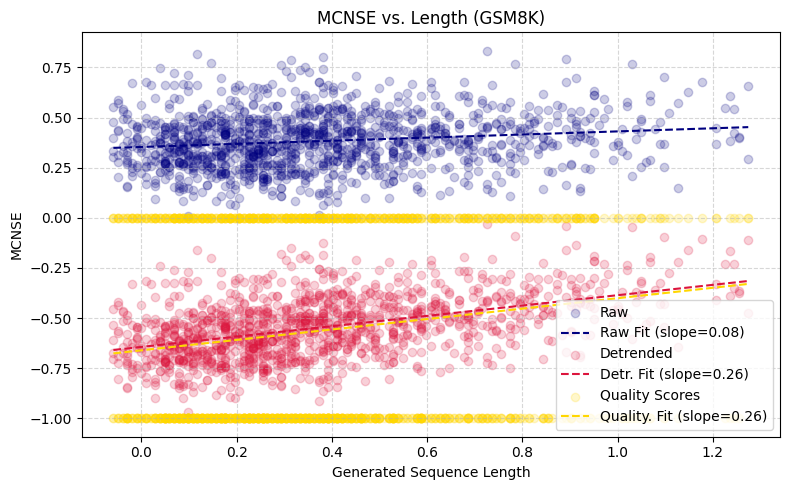

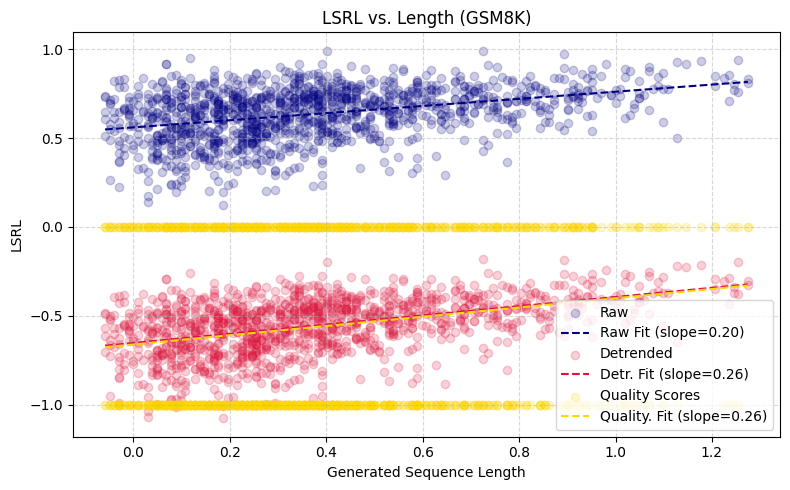

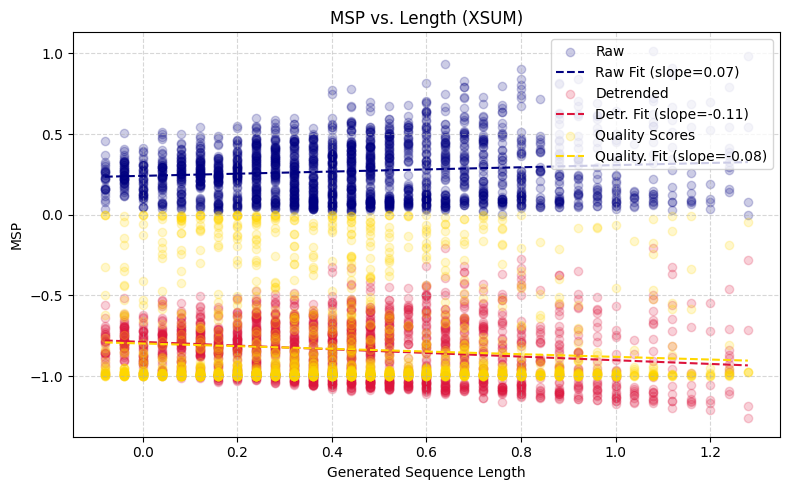

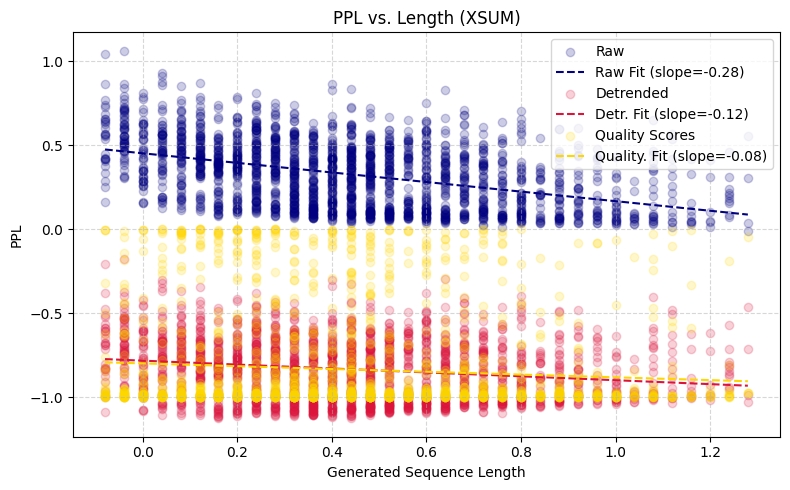

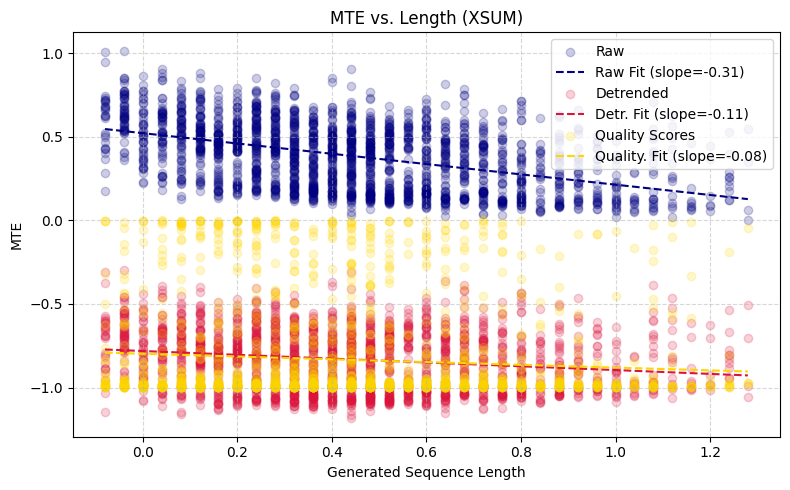

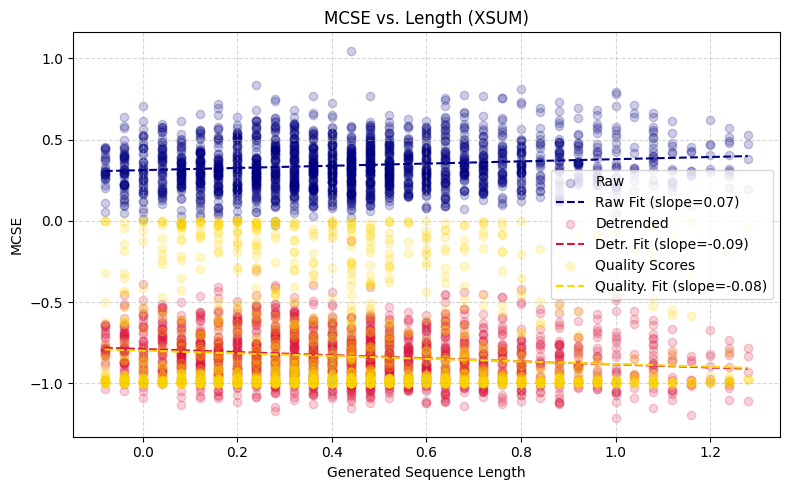

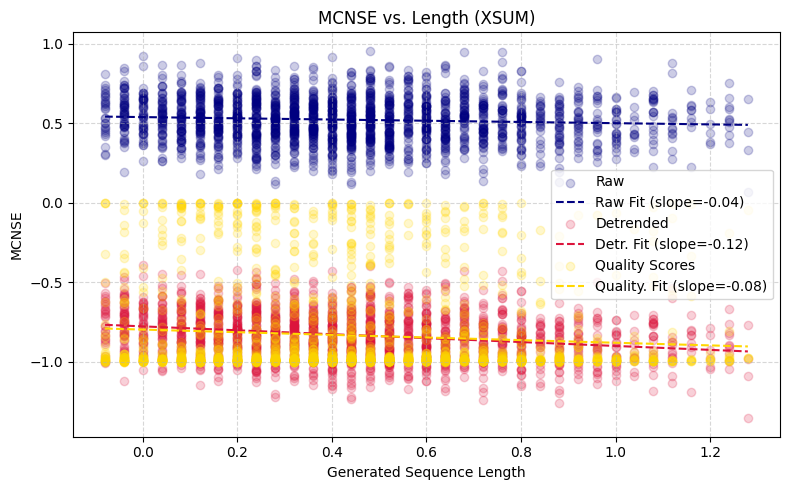

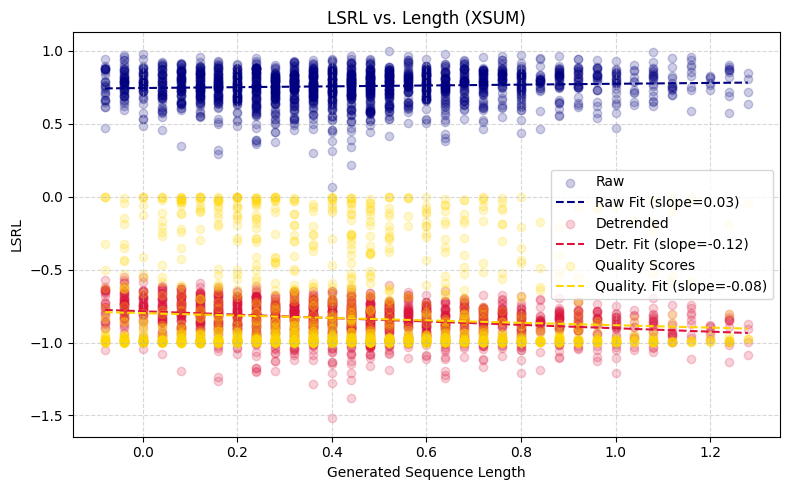

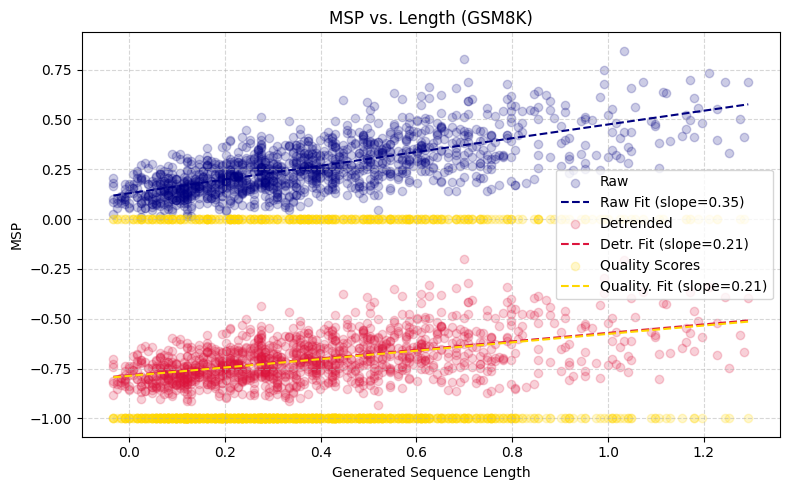

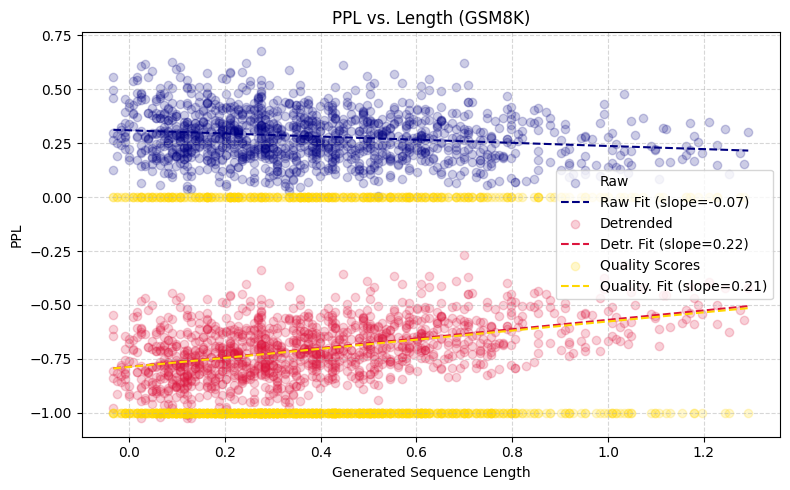

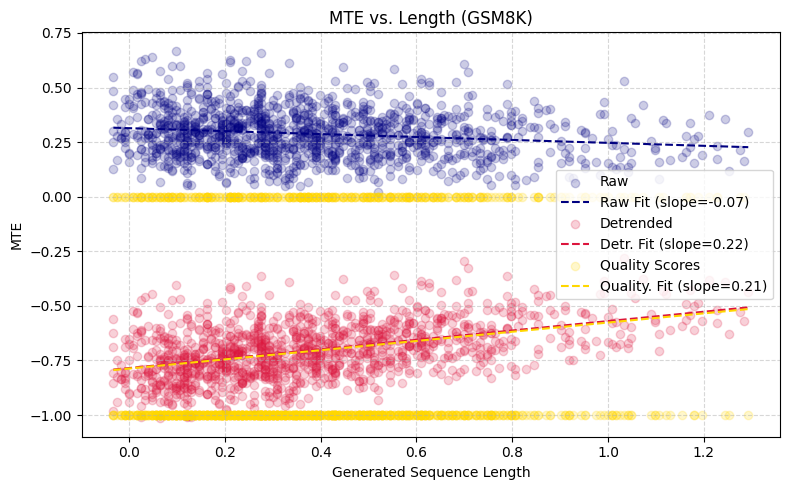

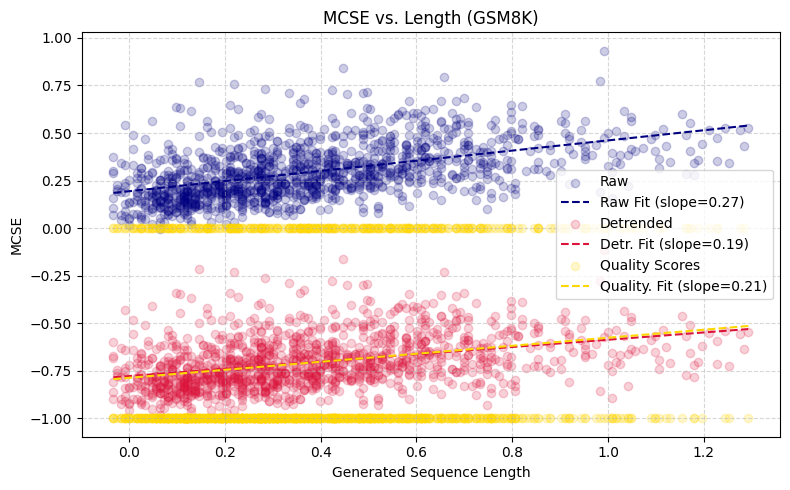

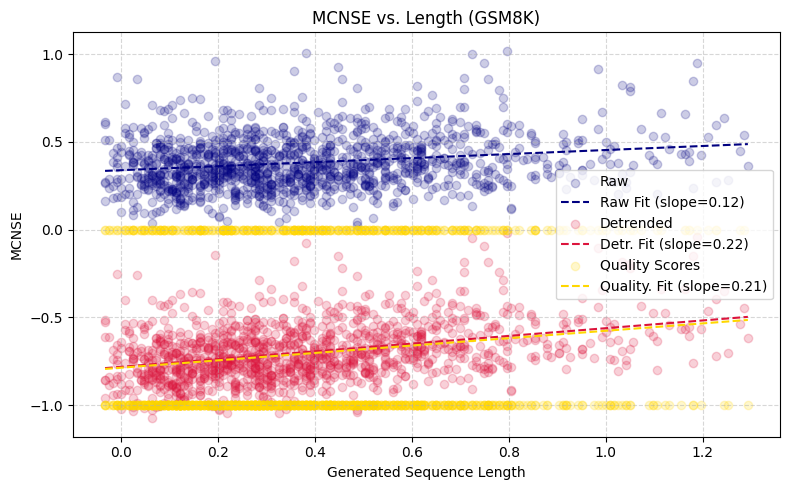

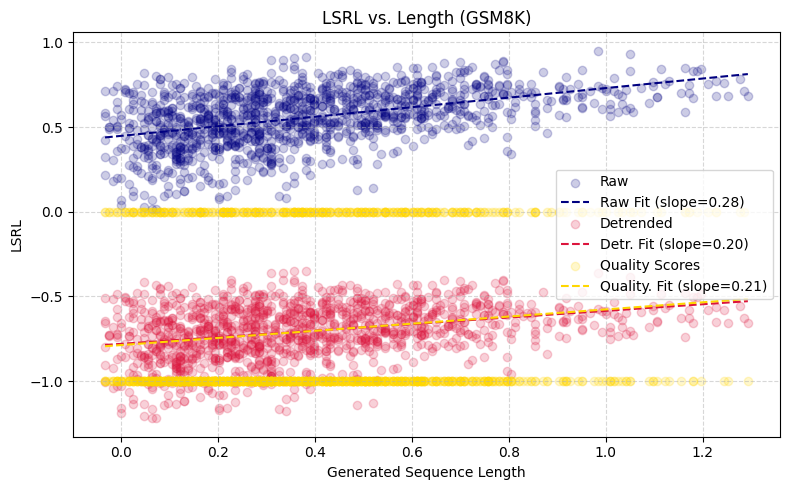

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
import numpy as np


def format_dataset_name(raw_name):
    try:
        prefix, lang_pair = raw_name.split("_")
        prefix = prefix.upper()

        if len(lang_pair) == 4:  # e.g., fren → Fr-En
            src = lang_pair[:2].capitalize()
            tgt = lang_pair[2:].capitalize()
            lang_fmt = f"{src}-{tgt}"
        else:
            lang_fmt = lang_pair.upper()

        return f"{prefix} {lang_fmt}"
    except Exception:
        return raw_name.upper()
def plot_raw_and_detrended_vs_length(
    lengths,
    raw_scores,
    detr_scores,
    metric_name='Metric',
    dataset_name='Dataset',
    save_path=None,
    quality_scores=None
):
    # Convert to numpy arrays
    lengths = np.array(lengths).reshape(-1)
    raw_scores = np.array(raw_scores).reshape(-1)
    detr_scores = np.array(detr_scores).reshape(-1)

    # Remove outliers: keep values between 5th and 95th percentile
    lower, upper = np.percentile(lengths, [2.5, 97.5])
    mask = (lengths >= lower) & (lengths <= upper)
    lengths = lengths[mask]
    raw_scores = raw_scores[mask]
    detr_scores = detr_scores[mask]
    quality_scores=quality_scores[mask]

    # Fit regressions
    reg_raw = LinearRegression().fit(lengths[:, None], raw_scores)
    reg_detr = LinearRegression().fit(lengths[:, None], detr_scores)
    slope_raw = reg_raw.coef_[0]
    slope_detr = reg_detr.coef_[0]

    _, _, _, pval_raw, _ = linregress(lengths, raw_scores)
    _, _, _, pval_detr, _ = linregress(lengths, detr_scores)

    # Prediction lines
    x_line = np.linspace(lengths.min(), lengths.max(), 100)
    y_raw_line = reg_raw.predict(x_line[:, None])
    y_detr_line = reg_detr.predict(x_line[:, None])

    if quality_scores[0] is not None:
        for i in range(len(quality_scores)):
            quality_scores[i] = -quality_scores[i]
        reg_qual = LinearRegression().fit(lengths[:, None], quality_scores)
        y_quality_line =reg_qual.predict(x_line[:, None])
        slope_qual = reg_qual.coef_[0]
        _, _, _, pval_qual, _ = linregress(lengths, quality_scores)


    # Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(lengths, raw_scores, color='navy', alpha=0.2, label='Raw')
    plt.plot(x_line, y_raw_line, '--', color='navy', label=f'Raw Fit (slope={slope_raw:.2f})')

    plt.scatter(lengths, detr_scores, color='crimson', alpha=0.2, label='Detrended')
    plt.plot(x_line, y_detr_line, '--', color='crimson', label=f'Detr. Fit (slope={slope_detr:.2f})')

    if quality_scores[0] is not None:
        plt.scatter(lengths, quality_scores, color='gold', alpha=0.2, label='Quality Scores')
        plt.plot(x_line, y_quality_line, '--', color='gold', label=f'Quality. Fit (slope={slope_qual:.2f})')

    plt.title(f"{metric_name} vs. Length ({format_dataset_name(dataset_name)})")
    plt.xlabel("Generated Sequence Length")
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)

model_type ='base'
# metric = 'Comet-wmt22-comet-da'
methods_dict = {
    'MaximumSequenceProbability': 'MSP',
    'Perplexity': 'PPL',
    'MeanTokenEntropy': 'MTE',
    'MonteCarloSequenceEntropy': 'MCSE',
    'MonteCarloNormalizedSequenceEntropy': 'MCNSE',
    'LexicalSimilarity_rougeL': 'LSRL',
}
models=['llama', 'gemma']
DATASETS = ['xsum', 'gsm8k']
for model in models:
    for dataset in DATASETS:
        metric ='AlignScoreInputOutput' if dataset=='xsum' else 'Accuracy'
        ue_methods =  list(methods_dict.values())
        ue_scores, _, _, lengths, quality = detrend_ue_w_quality([dataset], model, model_type, [metric], ue_methods, methods_dict, return_unprocessed=True)
        for ue_method in ue_methods:
            plot_raw_and_detrended_vs_length(lengths, ue_scores[f'{ue_method}_raw_full'][0], ue_scores[f'{ue_method}_detr_full'][0], metric_name=ue_method, dataset_name=dataset, save_path=f"{model}_{ue_method}_{dataset}_comparison.pdf", quality_scores=quality)